# Set data in two ranges to validate uncertainty increase and decrease along them

The technique used in this experiments series try to model uncertainty, that should minimum where there arre known data and maximum when distance to known data is bigger.

In this experiment we are going to set data in two ranges: (0,1) original experiment range and range (800,801), a range far away from first range to allow uncertainty to increase clearly between ranges and decrease again near second data range.
The uncertainty should be maximum in the middle of two known data ranges.


hipothesis: variance should increase between 1 and 800 and between 800 and 1200. It should be maximum at 400 and 1200, max distance between known data.

If you want to see the base experiment, you can get it at "initial validation" in this repository.


Original at: https://github.com/sthorn/deep-learning-explorations/blob/master/predicting-uncertainty.ipynb

### Imports 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as m
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import copy

%matplotlib inline

### Generate some random data

In [2]:
# Generate some linearly related data
n_samples = 10000
np.random.seed(4567)

We are going to create data for both ranges.
Firstly we prepare the x axis for ranges (0,1) and (800,801). Random.random values are intrinsically (0,1), so we only need to prepare (800,801) range.
Then we fill y axis with values with the original function. 

In [3]:
#X axis, with values between (0,1) intrinsically
x = np.random.random(n_samples) 

#Prepare (800,801) range in x axis
for position in range(800,900,1):
    x[position]=800+(0.01*(position-800))

#This function is the one used in original experiment for generating data
eps = np.random.normal(scale=1.0, size=n_samples) * 0.4*np.sin(x*4*np.pi)
y = 2*x + 1 + eps

Now, we visualize how data are in both ranges.

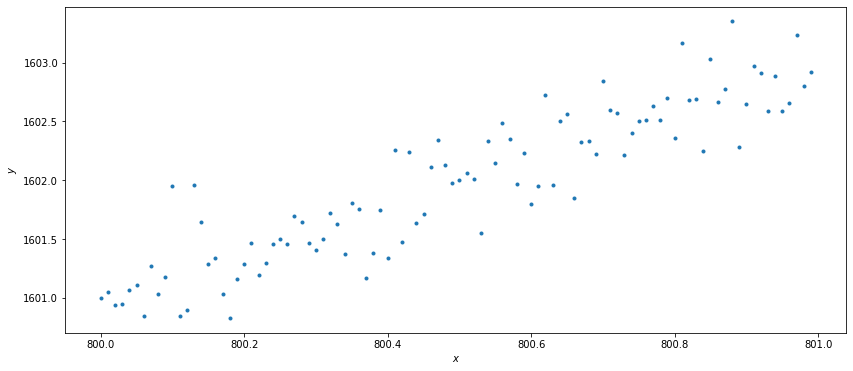

In [4]:
# Plot the data at (800,801)
plt.figure(figsize=(14,6))
plt.plot(x[800:900], y[800:900], '.')
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');

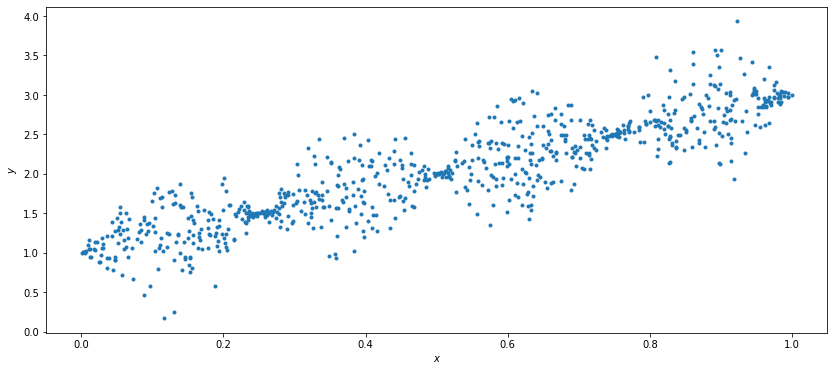

In [5]:
# Plot the data at (0,1)
plt.figure(figsize=(14,6))
plt.plot(x[0:800], y[0:800], '.')
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');

We can see how there is no data between the two ranges.

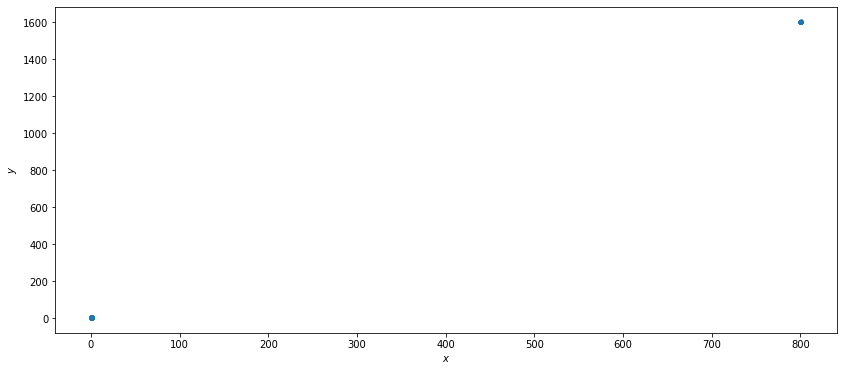

In [6]:
# Plot the entire data
plt.figure(figsize=(14,6))
plt.plot(x, y, '.')
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');

At this point, we prepare the data and the network for training. Sigma is the variable for uncertainty.

In [7]:
# Add in column of dummy zeros to represent sigma 
sigma = np.zeros(n_samples)
y = np.stack([y, sigma], axis=1)

In [8]:
# Reshape x for PyTorch
x = x.reshape(n_samples, 1)

## ¡¡WARNING!!

This is a experiment, we don't know the correct output. So we can't validate the output, and, indeed, we can't use validation data to validate the output. So we don't make the split between training and validation.

In [9]:
# Split into training and validation sets
#n_validation = 500
#x_val, x = x[:n_validation], x[n_validation:]
#y_val, y = y[:n_validation], y[n_validation:]

In [10]:
# Convert x and y to PyTorch Variables on the GPU
dtype = torch.FloatTensor
x = Variable(torch.from_numpy(x).type(dtype))
y = Variable(torch.from_numpy(y).type(dtype), requires_grad=False)

In [11]:
# Check shape ok for PyTorch - x should be (n x 1), y (n x 2)
x.shape, y.shape

(torch.Size([10000, 1]), torch.Size([10000, 2]))

### Create a simple network 

In [12]:
# Create a simple two-layer network with one input (x) and two outputs (y, sigma)
n_inputs = 1
n_outputs = 2
n_hidden = 1000
model = torch.nn.Sequential(torch.nn.Linear(n_inputs, n_hidden),
                            torch.nn.ReLU(),
                            torch.nn.Linear(n_hidden, n_outputs)
                           )

In [13]:
# Adam optimizer
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Custom loss function
This is where the magic happens.

In [14]:
def custom_loss(input, target):
    
    # Estimate target value for sigma with abs(y_pred - y)
    #
    #    actual y     is target[:,0]
    # predicted y     is input[:,0]
    #    actual sigma is target[:,1]
    # predicted sigma is input[:,1]
    
    # Use 'requires_grad == False' to prevent PyTorch from trying to differentiate 'target'
    target[:,1] = Variable((input[:,0].data - target[:,0].data).abs(), 
                           requires_grad=False)  
    # Return MSE loss 
    return F.mse_loss(input, target)

### Training loop 
We train this simple model with batch size equal to the whole dataset.

In [15]:
n_epochs = 10000
for i in range(n_epochs):
    
    # Calculate predicted y from x
    y_pred = model(x)
    
    # Calculate loss
    loss = custom_loss(y_pred, y)
    
    if i%500 == 0: print(f'epoch: {i:4}, loss: {loss.data:.3}',)

    # Backprop, first zeroing gradients
    optimizer.zero_grad()
    loss.backward()

    # Update parameters
    optimizer.step()

epoch:    0, loss: 2.44e+04
epoch:  500, loss: 0.0637
epoch: 1000, loss: 0.0617
epoch: 1500, loss: 0.0614
epoch: 2000, loss: 0.0612
epoch: 2500, loss: 0.061
epoch: 3000, loss: 0.0608
epoch: 3500, loss: 0.0607
epoch: 4000, loss: 0.0605
epoch: 4500, loss: 0.0603
epoch: 5000, loss: 0.0601
epoch: 5500, loss: 0.0599
epoch: 6000, loss: 0.0598
epoch: 6500, loss: 0.0596
epoch: 7000, loss: 0.0594
epoch: 7500, loss: 0.0591
epoch: 8000, loss: 0.0589
epoch: 8500, loss: 0.0586
epoch: 9000, loss: 0.0583
epoch: 9500, loss: 0.058


### Get predictions 

We get prediction for entire range (0,1200). It includes the data ranges and the ranges without data, between them and beyond them. Also, we define ranges for fine grain in theoretical maximum point (400) zone, theoretical minimum point (800) zone and original minimum point zone (0).

In [16]:
# Get predicted y and sigma
x_pred=np.arange(-1200,1200.0,10)
x_pred=x_pred.reshape(int(2400/10), 1)
x_pred_pytorch = Variable(torch.from_numpy(x_pred).type(dtype)) 
pred = model(x_pred_pytorch)
y_pred = pred[:,0].cpu().data
sigma_pred = pred[:,1].cpu().data

#The following ranges are for fine grain in high interest zones
x_pred_400=np.arange(399.5,400.5,0.01)
x_pred_400=x_pred_400.reshape(100,1)
x_pred_400_pytorch= Variable(torch.from_numpy(x_pred_400).type(dtype)) 
pred_400 = model(x_pred_400_pytorch)
y_pred_400 = pred_400[:,0].cpu().data
sigma_pred_400 = pred_400[:,1].cpu().data

x_pred_800=np.arange(799.5,800.5,0.01)
x_pred_800=x_pred_800.reshape(100,1)
x_pred_800_pytorch= Variable(torch.from_numpy(x_pred_800).type(dtype)) 
pred_800 = model(x_pred_800_pytorch)
y_pred_800 = pred_800[:,0].cpu().data
sigma_pred_800 = pred_800[:,1].cpu().data

x_pred_0=np.arange(-0.5,0.5,0.01)
x_pred_0=x_pred_0.reshape(100,1)
x_pred_0_pytorch= Variable(torch.from_numpy(x_pred_0).type(dtype))
pred_0 = model(x_pred_0_pytorch)
y_pred_0 = pred_0[:,0].cpu().data
sigma_pred_0 = pred_0[:,1].cpu().data


### Plot results

The first plot is the one showing the behaviour uncertainty 

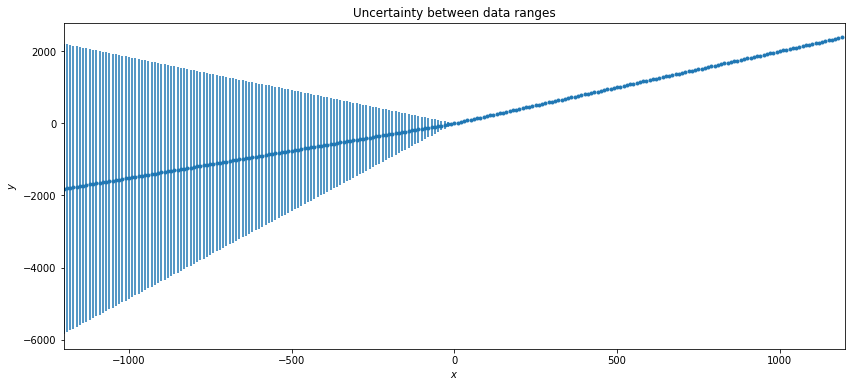

In [17]:
# Plot predictions and their errors
plt.figure(figsize=(14,6))
plt.errorbar(x_pred, y_pred, yerr=sigma_pred, fmt='.');
#plt.errorbar(x_val, y_pred, fmt='.');
# One standard-deviation envelope
xs = np.linspace(0.0, 1.0, 50)
err = 0.4*np.sin(xs*4*np.pi)
plt.fill_between(xs, 2*xs+1-err, 2*xs+1+err, facecolor='orange', alpha=0.5, edgecolor='none');
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');
plt.xlim(-1200,1200);
plt.title('Uncertainty between data ranges');

The expected behaviour was that uncertainty increases from 0, being 400 maximum, decreases at 800 and increases again to 1200. According to the plot, that is not the result. The uncertainty seems to be the same in the entire positive range. However, it increases in negative range, where there is no known data.


We make zoom in order to see how is the uncertainty at 400, that should be maximum, and at 800, that should be minimum.

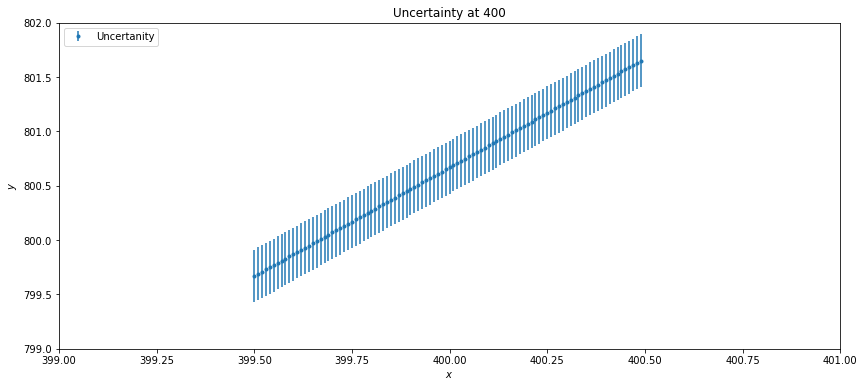

In [18]:
# Plot predictions at 400
plt.figure(figsize=(14,6))
plt.errorbar(x_pred_400, y_pred_400, yerr=sigma_pred_400, fmt='.');
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');
plt.xlim(399,401);
plt.ylim(799,802);
plt.title('Uncertainty at 400');
plt.legend(['Uncertanity'], loc='upper left', );

The plot shows uncertainty is +-0.25 at 400.

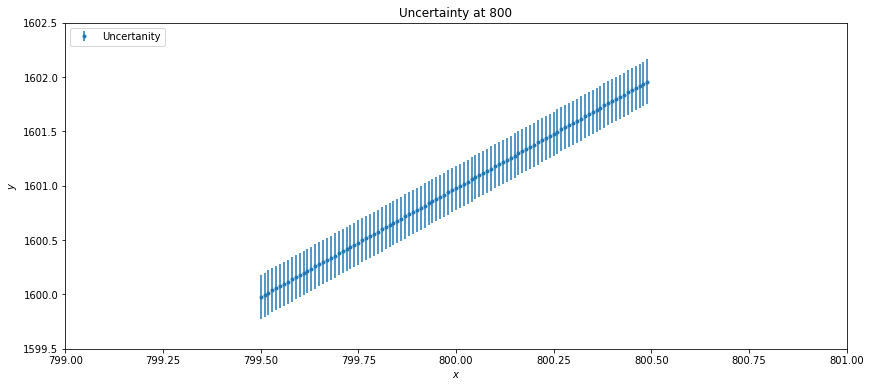

In [19]:
# Plot predictions at 800
plt.figure(figsize=(14,6))
plt.errorbar(x_pred_800, y_pred_800, yerr=sigma_pred_800, fmt='.');
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');
plt.xlim(799,801);
plt.ylim(1599.5,1602.5);
plt.title('Uncertainty at 800');
plt.legend(['Uncertanity'], loc='upper left', );

The plot shows uncertainty is +-0.25 at 800. The uncertainty is the same at 400 and at 800, so the model doesn't model uncertainty based on known data proximity.

In order to verify behaviour, we can plot the data at 0, as in original experiment.

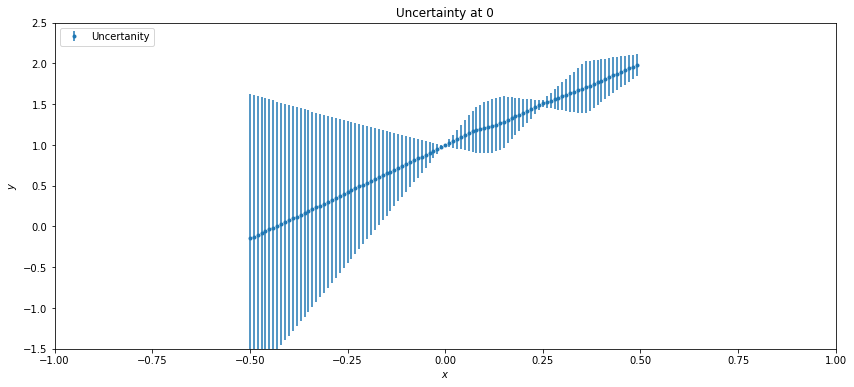

In [20]:
# Plot predictions at 0
plt.figure(figsize=(14,6))
plt.errorbar(x_pred_0, y_pred_0, yerr=sigma_pred_0, fmt='.');
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');
plt.xlim(-1,1);
plt.ylim(-1.5,2.5);
plt.title('Uncertainty at 0');
plt.legend(['Uncertanity'], loc='upper left', );

We can see how near zero it maintains the sine shape, but only in positive zone and neither at 400 zone, so it could be overfitting.

### Conclusions

The results are the model simply uses a variance value for the entire positive range. So, the variance doesn't increase between known data, then the hypothesis failed.